# Load libraries

In [1]:
import sys
import glob
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_score, \
                                    cross_validate,cross_val_predict, StratifiedKFold, KFold, GroupKFold, LeavePGroupsOut
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from neurocombat_sklearn import CombatModel
from scipy.stats import normaltest
from mlxtend.evaluate import permutation_test

# Read freesurfer stats

In [2]:
def readFiles(feature_path, behavior_path,target_str, covar_list, subj_excl, study_ext):
    
    feature = pd.read_csv(feature_path, sep = '\t',index_col=0)
    for i in feature.index:
        feature.rename(index={i:i + study_ext},inplace=True)

    subj_excl_v1 = []
    
    if study_ext in {'_s1'} or study_ext in {'_s2'}:
        for i in subj_excl:
            subj_excl_v1.append('sub-' + i.zfill(3) + '_T1w' + study_ext)
    else:
        for i in subj_excl:
            subj_excl_v1.append('HC' + i.zfill(2) + study_ext)
    
    if not subj_excl:
        feature_v1 = feature
    else:
        feature_v1 = feature.drop(subj_excl_v1, axis=0)
    
    behavior = pd.read_csv(behavior_path)
    behavior.set_index('ID_EXT',inplace=True)
    
    target = behavior[target_str]
    df_merge = pd.merge(feature_v1, target, left_index=True, right_index=True, how= 'left') 
    
    age_cov = behavior[covar_list[0]]
    df_merge_age = pd.merge(df_merge, age_cov, left_index=True, right_index=True, how= 'left')   
    
    sex_cov = behavior[covar_list[1]]
    df_merge_age_sex = pd.merge(df_merge_age, sex_cov, left_index=True, right_index=True, how= 'left')   
    df_merge_age_sex.dropna(inplace=True)
    
    return df_merge_age_sex

# Models

In [3]:
class models_ml:
    def __init__(self, model_name, feature_size):
        self.model_name = model_name
        self.feature_size = feature_size
    
    def get_model(self):
        if self.model_name in {'modelLasso_nf'}:
            return self.modelLasso_nf()
        
        
    def modelLasso_nf(self):
        model = Pipeline([         
                          ('model_Lasso', Lasso(normalize=False,max_iter=100000))
                         ])
        p_grid = {
                  'model_Lasso__alpha':[1e-9, 1e-8, 1e-7, 1e-6,1e-5,1e-4,1e-3, 1e-2, 
                                        0.1, 1e+2, 1e+3, 10000,100000,1000000, 10000000, 100000000, 1000000000]} 
        return model, p_grid

# Study 1-3 data

In [4]:
s='s1_'
s_ = '_s1'
rpn = '_S1'
files = sorted(glob.glob("../data/data_unbias/s1*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex',''],
                           subj_excl = ['35'], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s1 = appended_data
np_s1 = np.size(feature_s1,0)
feature_s1['batch'] = np.full((np_s1), 1, dtype=int)

s='_s2'
s_ = '_s2'
rpn = '_S2'
files = sorted(glob.glob("../data/data_unbias/s2*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex'],
                           subj_excl = [], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s2 = appended_data
np_s2 = np.size(feature_s2,0)
feature_s2['batch'] = np.full((np_s2), 2, dtype=int)

s='_s3'
s_ = '_s3'
rpn = '_S3'
files = sorted(glob.glob("../data/data_unbias/s3*"))
appended_data = []
for i in files:
    print(i)
    temp = readFiles(feature_path = i, 
                           behavior_path = ('../data/data_unbias/RPN' + rpn + '_behavior_confounder_v1_dtvalues.csv'),
                           target_str = 'QST',
                           covar_list = ['Age','sex'],
                           subj_excl = [], 
                           study_ext = s_)
    appended_data.append(temp)

appended_data = pd.concat(appended_data, axis=1)
feature_s3 = appended_data
np_s3 = np.size(feature_s3,0)
feature_s3['batch'] = np.full((np_s3), 3, dtype=int)

../data/data_unbias\s1_lh_thickness.txt
../data/data_unbias\s1_lh_volume.txt
../data/data_unbias\s1_rh_thickness.txt
../data/data_unbias\s1_rh_volume.txt
../data/data_unbias\s1_subcortical_volume.txt
../data/data_unbias\s2_lh_thickness.txt
../data/data_unbias\s2_lh_volume.txt
../data/data_unbias\s2_rh_thickness.txt
../data/data_unbias\s2_rh_volume.txt
../data/data_unbias\s2_subcortical_volume.txt
../data/data_unbias\s3_lh_thickness.txt
../data/data_unbias\s3_lh_volume.txt
../data/data_unbias\s3_rh_thickness.txt
../data/data_unbias\s3_rh_volume.txt
../data/data_unbias\s3_subcortical_volume.txt


# Select cortical thickness stats

In [5]:
features = pd.concat([feature_s1, feature_s2, feature_s3], axis = 0)
X = features.drop(['eTIV','Age','sex','QST','batch','lh_MeanThickness_thickness',
                                 'rh_MeanThickness_thickness','3rd-Ventricle',
                                 '4th-Ventricle','5th-Ventricle','Left-Lateral-Ventricle',
                                 'Left-Inf-Lat-Vent','Left-Cerebellum-White-Matter','Left-vessel',
                                 'Left-choroid-plexus', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent',
                                 'Right-Cerebellum-White-Matter','Right-vessel', 'WM-hypointensities',
                                 'Left-WM-hypointensities','Right-WM-hypointensities',
                                 'non-WM-hypointensities','lhCerebralWhiteMatterVol','CortexVol',
                                 'Left-non-WM-hypointensities','Right-non-WM-hypointensities',
                                 'rhCerebralWhiteMatterVol','TotalGrayVol',
                                 'lhSurfaceHoles','rhSurfaceHoles','SurfaceHoles','EstimatedTotalIntraCranialVol',
                                 'BrainSegVolNotVentSurf', 'BrainSegVol-to-eTIV','MaskVol-to-eTIV',
                                 'MaskVol','CerebralWhiteMatterVol','BrainSegVolNotVent','BrainSegVol','CSF',
                                 'Left-Cerebellum-Cortex','Brain-Stem','Left-Accumbens-area','Left-VentralDC',
                                 'Right-Cerebellum-Cortex','Right-Accumbens-area','Right-VentralDC',
                                 'Right-choroid-plexus','Optic-Chiasm','CC_Anterior','CC_Posterior','CC_Mid_Posterior',
                                 'CC_Central','CC_Mid_Anterior','lhCortexVol','rhCortexVol',
                                 'SubCortGrayVol','SupraTentorialVol','SupraTentorialVolNotVent',
                                 'SupraTentorialVolNotVentVox','lh_WhiteSurfArea_area','rh_WhiteSurfArea_area'],axis=1, errors='ignore')

# Compose final X, y, imaging covariates

In [6]:
covariates_dup = features[['Age','sex','batch']]
covariates =covariates_dup.T.drop_duplicates().T  
covariates['eTIV'] = features['EstimatedTotalIntraCranialVol']
target_dup = features['QST']
covariates['mThickness']= (features['lh_MeanThickness_thickness']+features['rh_MeanThickness_thickness']).div(2)
target = target_dup.T.drop_duplicates().T
cov = np.array(covariates)

# Select a feature set

In [7]:
# SUBCORTICAL volumes - 2
X_subcortical = X.iloc[:,136:148]
print(X.columns[136:148])
print('shape = ', X_subcortical.shape)
print('*********************************')

# CORTICAL thickness
X_lhcorticalthickness = X.iloc[:,0:34]
print(X.columns[0:34])
print('shape = ', X_lhcorticalthickness.shape)
print('*********************************')
X_rhcorticalthickness = X.iloc[:,68:102]
print(X.columns[68:102])
print('shape = ', X_rhcorticalthickness.shape)
print('*********************************')

Index(['Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala'],
      dtype='object')
shape =  (131, 12)
*********************************
Index(['lh_bankssts_thickness', 'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thick

# Groups

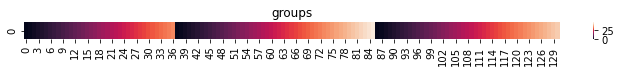

In [8]:
groups=np.zeros(len(X), dtype=int)
site = []
clr = np.zeros(len(X), dtype=float)
g=0
i=0
while i < np_s1:
    groups[i] = g
    s_name = 'study 1'
    site.append(s_name)
    #groups[i+1] = g
    clr[i] = 0.1
    i += 1
    g += 1
  

g=0
i=np_s1
while i < np_s1+np_s2:
    groups[i] = g
    s_name = 'study 2'
    site.append(s_name)
    clr[i] = 0.5
    #groups[i+1] = g
    i += 1
    g += 1


g=0
i=np_s1+np_s2
while i < len(X):
    groups[i] = g
    s_name = 'study 3'
    site.append(s_name)
    clr[i] = 0.8
    i += 1
    g += 1
    

plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show() 
groups  
sites = pd.DataFrame(site)
sites.columns = ['centre']
sites.index = covariates.index
clrs = pd.DataFrame(clr)
clrs.columns = ['centre']
clrs.index = sites.index

# do not Regress out eTIV

In [9]:
X_feature = pd.concat([X_lhcorticalthickness.div(covariates['mThickness'],axis=0),
                       X_rhcorticalthickness.div(covariates['mThickness'],axis=0)],axis=1)
y=target['QST']
X_feature['eTIV'] = covariates['eTIV'].div(1000000)
X_norm = X_feature
X_norm.head(2)

,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,eTIV
sub-004_T1w_s1,1.022095,1.085502,1.007340,0.814326,1.414503,1.103847,0.981817,1.101454,0.926386,0.882120,...,0.927582,1.105043,0.845033,1.166855,1.032463,1.082711,1.439228,0.981020,1.245815,1.563487
sub-005_T1w_s1,0.970548,1.036479,1.019689,0.750229,1.159334,1.043441,0.995119,1.060231,0.939425,0.913625,...,0.963996,1.155239,0.889874,1.117154,1.009861,1.020099,1.235913,0.974643,1.117154,1.777286


In [10]:
covariates.head()

,Age,sex,batch,eTIV,mThickness
sub-004_T1w_s1,25.552361,1.0,1.0,1.563487e+06,2.507595
sub-005_T1w_s1,23.800137,1.0,1.0,1.777286e+06,2.441920
sub-006_T1w_s1,33.453799,1.0,1.0,1.581288e+06,2.492065
sub-007_T1w_s1,26.119097,1.0,1.0,1.648965e+06,2.489610
sub-008_T1w_s1,25.445585,1.0,1.0,1.584414e+06,2.546875


# Machine learning

In [11]:
model_try = 'modelLasso_nf'
model_steps = 'model_Lasso'
feature_size = np.size(X_norm, 1)
print('feature size =' + str(feature_size))
model_get = models_ml(model_try, feature_size)
model, p_grid = model_get.get_model()
cov = np.array(covariates)

feature size =69


In [12]:
np.arange(0,np.size(X_feature,1),1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68])

In [13]:
outer_cv = GroupKFold(10)
inner_cv = GroupKFold(10)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
results_cv = []
all_models = []
best_params = []
predicted = np.zeros(len(y))
pred_test = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_norm))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_norm))   
                                    
#print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X_norm, y, groups=groups):
    group_train = groups[train]  
    #########################################################################################
    # use comabt 
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X_norm.iloc[train],
                                   np.array([covariates.batch.values[train]]).transpose(),
                                   np.array([covariates.sex.values[train]]).transpose(),
                                   np.array([covariates.Age.values[train]]).transpose()
                                       )
    
    #########################################################################################                                    
    # 1. fit LASSO on combat model without TIV as a feature, ind = 68                                    
    clf.fit(X_train_combat[:,0:68], y[train], groups=group_train)
    # 2. predict same training data with the best estimator
    pred_train = clf.predict(X_train_combat[:,0:68])
    # 3. use training data and batch corrected TIV to fit a linear regression model
    lr = LinearRegression()
    lr.fit(pd.DataFrame(X_train_combat[:,68]),pred_train)

    
    #########################################################################################
    #use combat
    X_test_combat = comb.transform(X_norm.iloc[test],
                                   np.array([covariates.batch.values[test]]).transpose(),
                                   np.array([covariates.sex.values[test]]).transpose(),
                                   np.array([covariates.Age.values[test]]).transpose()
                                  )
    #                           
    #########################################################################################
    #print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
    #all_models.append(clf.best_estimator_)
    #best_params.append(clf.best_params_)
    print(test)
    # 4. use batch corrected test data to predict with LASSO
    pred_test[test] = clf.predict(X_test_combat[:,0:68])
    # 5. use batch corrected TIV to predict test features.
    pred_test_using_tiv = lr.predict(pd.DataFrame(X_test_combat[:,68]))
    # 6. consider residuals as final predicted QST from test
    predicted[test] = pred_test[test] - pred_test_using_tiv
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat[:,0:68], y[test])
    i = i+1
    
    weights=clf.best_estimator_.named_steps[model_steps].coef_
    weights_idx = np.nonzero(weights)
    res = pd.DataFrame([weights[weights_idx], X_feature.columns[weights_idx]])
    main = res.T.sort_values(by=0)
    #print(main)
    weights_res = weights.flatten()
    results_cv.append(weights_res)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
p_corr = permutation_test(predicted, y,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42)
print('nested pearson r = ' + str(np.corrcoef(predicted, y)[0,1]) + ' permutation p =' + str(round(p_corr,4)) )

df_results_res = pd.DataFrame(results_cv)
col_names = X_norm.columns[0:68]
df_results_res.columns = col_names

df_results_res.to_csv('nested_cv_results.csv')
new = df_results_res.loc[:, (df_results_res != 0).any(axis=0)]
new_mean = new.mean(axis = 0)
#new_mean.to_csv('resultsNestedCV')
new_mean.sort_values(ascending=False)

Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  3  13  24  32  40  50  61  69  80  89  99 110 118 129]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  2  12  23  34  39  49  60  71  81  88  98 109 120 130]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  1  11  21  30  38  48  58  67  83  87  97 107 116]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[ 10  20  22  29  47  57  59  66  84  96 106 108 115]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  0   9  19  28  37  46  56  65  82  86  95 105 114]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  8  18  27  36  45  55  64  73  85  94 104 113 122]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  7  17  26  31  44  54  63  68  93 103 112 117]
Fitting 10 folds for each of 17 candidates, totalling 170 fits
[  6  16  25  43  53  62  74  77  92 102 111 123 126]
Fitting 10 folds for each of 17 candidates, totalling 170 fi

rh_frontalpole_thickness                 0.113517
lh_entorhinal_thickness                 -0.010027
rh_parahippocampal_thickness            -0.024850
lh_temporalpole_thickness               -0.209141
lh_parahippocampal_thickness            -0.531616
rh_rostralanteriorcingulate_thickness   -1.665483
dtype: float64

# Figure 2 part 1: scatter plot predictions (multi-centre) + learning curve

In [14]:
clf.best_estimator_

Pipeline(steps=[('model_Lasso', Lasso(alpha=0.01, max_iter=100000))])

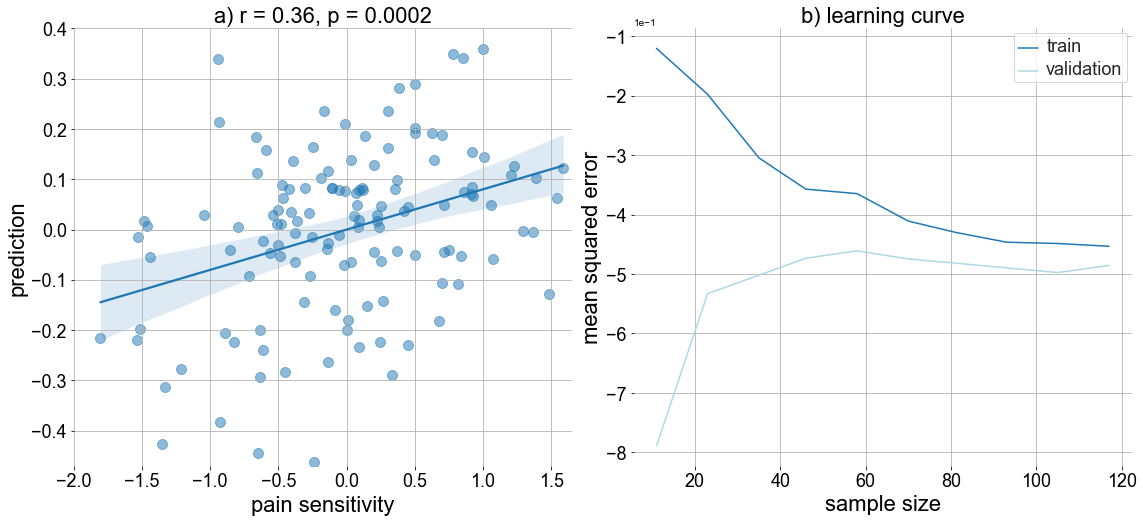

In [15]:
#############################LEARNING CURVE##########################################################
fs = 22
fs_title = 24
fs_tick = 18

comb_lc = CombatModel()
X_feature_combat = comb_lc.fit_transform(X_feature,
                                np.array([covariates.batch.values]).transpose(),
                                np.array([covariates.sex.values]).transpose(),
                                np.array([covariates.Age.values]).transpose()
                                    )


cv = GroupKFold(10)
train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_feature_combat[:,0:68], y, groups=groups, 
                                                        cv=cv, scoring="neg_mean_squared_error", n_jobs=None,  
                                                        random_state=None,shuffle=False,
                                                        train_sizes = np.linspace(0.1, 1, num=10))

temp_train = pd.DataFrame(train_scores)
temp_test = pd.DataFrame(test_scores)
train_mean = temp_train.mean(axis=1)
train_std = temp_train.std(axis=1)
test_mean = temp_test.mean(axis=1)
test_std = temp_test.std(axis=1)

fig, (axs1,axs2) = plt.subplots(ncols=2, figsize=(16,8), sharex=False, sharey=False)

fig.tight_layout(pad=6)
sns.set_style('ticks')
axs2.grid(True)
axs2.spines['top'].set_visible(False)
axs2.spines['bottom'].set_visible(False)
axs2.spines['right'].set_visible(False)
axs2.spines['left'].set_visible(False)
axs2.set_title('b) learning curve',fontsize=fs)
axs2.set_xlabel('sample size',fontsize=fs)
axs2.set_ylabel('mean squared error',fontsize=fs)



g=sns.lineplot(train_sizes,train_mean,ax=axs2,label='train')
g=sns.lineplot(train_sizes,test_mean,ax=axs2, label='validation', color='lightblue')
axs2.tick_params(axis='x', which='major', labelsize=fs_tick)
axs2.tick_params(axis='y', which='major', labelsize=fs_tick)
plt.setp(g.get_legend().get_texts(), fontsize='18') # for legend text

#plt.suptitle('Multi-center model predicting pain sensitivity',fontsize=fs_title, fontweight = "bold" )
g.lines[0].set_label('train set')
axs2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#plt.rc('font', size=18)

##################################POOLED CORRELATION##################################################
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
axs1.tick_params(axis='x', which='major', labelsize=fs_tick)
axs1.tick_params(axis='y', which='major', labelsize=fs_tick)
g=sns.regplot(x='QST', y='predicted',data=data,scatter=True, ax =axs1, color ='tab:blue', scatter_kws={'alpha':0.5, 's':100} )

axs1.spines['top'].set_visible(False)
axs1.spines['bottom'].set_visible(False)
axs1.spines['right'].set_visible(False)
axs1.spines['left'].set_visible(False)
axs1.set_xlabel('pain sensitivity',fontsize=fs)
axs1.set_ylabel('prediction',fontsize=fs)
axs1.set_xlim([-2, 1.65])
axs1.set_ylim([-.47, .4])
axs1.grid(True)

c_temp=round(np.corrcoef(data['predicted'],data['QST'])[0,1],2)
p_temp =round(permutation_test(data['predicted'],data['QST'],
                           func=lambda x, y: np.abs(np.corrcoef(x, y))[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),4 )
#g.set(title='a) multi-centre ' + '(r = ' + str(c_temp) + ', p = ' + str(p_temp) + ')' , fontsize=14)
#axs1.set_title('a) multi-center ' + '(r = ' + str(c_temp) + ', p = ' + str(p_temp) + ')' , fontsize=18)
axs1.set_title('a) r = ' + str(c_temp) + ', p = ' + str(p_temp)  , fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.tight_layout
#axs1.set_xticklabels(axs1.get_xmajorticklabels(), fontsize = 13)
#axs1.set_yticklabels(axs1.get_ymajorticklabels(), fontsize = 13)
plt.savefig("../output/manuscript_f1-a-b.jpg", dpi=1200, bbox_inches = 'tight')


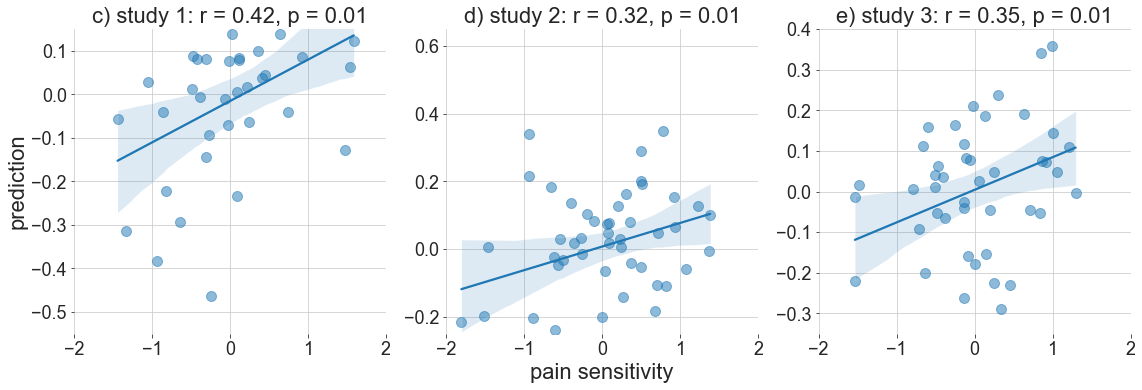

In [16]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=3, figsize=(16,6), sharex=False, sharey=False)

##########################################################################################################
col=0
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s1 = data.iloc[0:np_s1,:]
g=sns.regplot(x='QST', y='predicted',data=data_s1,scatter=True, ax =axs[col], color ='tab:blue', scatter_kws={'alpha':0.5, 's':100})
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
#plt.suptitle('Out-of-center generalization predictions', fontsize= 24, fontweight = "bold")
axs[col].set_xlabel('')
axs[col].set_ylabel('prediction', fontsize = 22)
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.55, .15])
axs[col].grid(True)
c_temp=round(np.corrcoef(data_s1['QST'], data_s1['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s1['QST'],data_s1['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2 )
axs[col].set_title('c) study 1: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp), fontsize=22)
##########################################################################################################

col=1
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s2 = data.iloc[np_s1:np_s1+np_s2,:]
g=sns.regplot(x='QST', y='predicted',data=data_s2,scatter=True, ax =axs[col],color ='tab:blue', scatter_kws={'alpha':0.5, 's':100} )
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
axs[col].set_xlabel('pain sensitivity', fontsize = 22)
axs[col].set_ylabel('')
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.25, .65])
axs[col].grid(True)
c_temp=round(np.corrcoef(data_s2['QST'], data_s2['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s2['QST'],data_s2['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2 )
axs[col].set_title('d) study 2: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp) , fontsize=22 )

##########################################################################################################

col=2
data = pd.DataFrame(y)
predicted = pd.DataFrame(predicted)
predicted.index = data.index
predicted.columns = ['predicted']
data = pd.concat([data, predicted,sites],axis=1)
data_s3 = data.iloc[np_s1+np_s2:np_s1+np_s2+np_s3]
g=sns.regplot(x='QST', y='predicted',data=data_s3,scatter=True, ax =axs[col], color ='tab:blue', scatter_kws={'alpha':0.5, 's':100})
axs[col].tick_params(axis='x', which='major', labelsize=18)
axs[col].tick_params(axis='y', which='major', labelsize=18)
axs[col].spines['top'].set_visible(False)
axs[col].spines['bottom'].set_visible(False)
axs[col].spines['right'].set_visible(False)
axs[col].spines['left'].set_visible(False)
axs[col].set_xlim([-2, 2])
axs[col].set_ylim([-.35, .4])
axs[col].grid(True)
axs[col].set_xlabel('')
axs[col].set_ylabel('')
c_temp=round(np.corrcoef(data_s3['QST'], data_s3['predicted'])[0,1],2)
p_temp =round(permutation_test(data_s3['QST'],data_s3['predicted'],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=10000,
                           seed=42),3)
axs[col].set_title('e) study 3: ' + 'r = ' + str(c_temp) + ', p = ' + str(p_temp) , fontsize=22 )
plt.tight_layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../output/manuscript_sf1.jpg", dpi=1200, bbox_inches = 'tight')


# Figure 3: correlations for QST with features of importance

In [17]:
comb_lc = CombatModel()
X_feature_combat = comb_lc.fit_transform(X_feature,
                                np.array([covariates.batch.values]).transpose(),
                                np.array([covariates.sex.values]).transpose(),
                                np.array([covariates.Age.values]).transpose()
                                    )
df_X_feature_combat_whole = pd.DataFrame(X_feature_combat)
df_X_feature_combat_whole.index = X_feature.index
df_X_feature_combat_whole.columns = X_feature.columns                                    
res = []                        
for q in np.arange(0,np.size(X_feature_combat,1),1):
    lr_features = LinearRegression()
    lr_features.fit(pd.DataFrame(X_feature_combat[:,68]),X_feature_combat[:,q])
    lr_features_pred = lr_features.predict(pd.DataFrame(X_feature_combat[:,68]))
    resid = X_feature_combat[:,q] - lr_features_pred
    res.append(resid)
X_feature_combat_tiv = pd.DataFrame(res)
X_feature_importance = X_feature_combat_tiv.transpose()
X_feature_importance.columns = X_feature.columns
X_feature_importance.index = X_feature.index
X_feature_importance['predicted'] = predicted
X_feature_importance['predicted_without_tiv_corr'] = pred_test

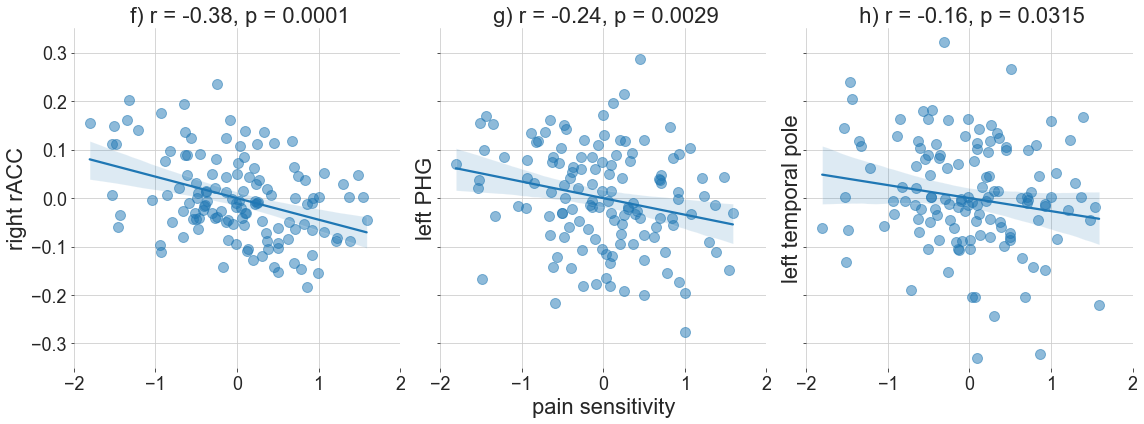

In [18]:
fs = 22
fs_title = 24
fs_tick = 18
X_combat_racc = X_feature_importance['rh_rostralanteriorcingulate_thickness']
X_combat_lphg = X_feature_importance['lh_parahippocampal_thickness']
X_combat_ltp = X_feature_importance['lh_temporalpole_thickness']

list = [X_combat_racc,X_combat_lphg,X_combat_ltp]
names = ['right rACC', 'left PHG','left temporal pole']

j=0
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=3, figsize=(16, 6), sharex=True, sharey=True)
for i in list:
    data = pd.DataFrame(y)
    predicted_ = pd.DataFrame(i)
    predicted_.index = data.index
    predicted_.columns = ['pr']
    data = pd.concat([data, predicted_,sites],axis=1)
    data.head()

    #g=sns.lmplot(data=data, x='QST', y='pr', hue = 'centre', fit_reg=False, legend=False)
    g=sns.regplot(x='QST', y='pr',data=data,scatter=True, ax =axs[j], color ='tab:blue', scatter_kws={'alpha':0.5, 's':100})
    axs[j].tick_params(axis='x', which='major', labelsize=fs_tick)
    axs[j].tick_params(axis='y', which='major', labelsize=fs_tick)
    axs[j].spines['top'].set_visible(False)
    axs[j].spines['bottom'].set_visible(False)
    axs[j].spines['right'].set_visible(False)
    axs[j].spines['left'].set_visible(False)
    axs[j].set_xlim([-2, 2])
    axs[j].set_ylim([-.35, .35])
    axs[j].grid(True)
    
    if j==1:
        axs[j].set_xlabel('pain sensitivity', fontsize = fs)
    else:
        g.set(xlabel='')
    axs[j].set_ylabel(names[j], fontsize = fs)
    c_temp=round(np.corrcoef(data['QST'],data['pr'])[0,1],2)
    p_temp =round(permutation_test(data['QST'],data['pr'],
                               func=lambda x, y: -np.corrcoef(x, y)[0,1],
                               method='approximate',
                               num_rounds=10000,
                               seed=42),4 )
    if j == 0:
        axs[j].set_title(' f) r = ' + str(c_temp) + ', p = ' + str(round(p_temp,4)), fontsize = fs)
    
    if j == 1:
        axs[j].set_title(' g) r = ' + str(c_temp) + ', p = ' + str(round(p_temp,4)), fontsize = fs)
    if j == 2:
        axs[j].set_title(' h) r = ' + str(c_temp) + ', p = ' + str(round(p_temp,4)), fontsize =fs)
    
    j+=1
#plt.suptitle('Cortical regions driving pain sensitivity predictions',fontsize=fs_title, fontweight = "bold")
plt.tight_layout()
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig( '../output/manuscript_f1f-h.jpg', dpi=1200, bbox_inches = 'tight')


In [19]:
behavior_1 = pd.read_csv('../data/data_unbias/RPN_S1_behavior_confounder_v1.csv', sep = ',',index_col=0)
behavior_2 = pd.read_csv('../data/data_unbias/RPN_S2_behavior_confounder_v1.csv', sep = ',',index_col=0)
behavior_3 = pd.read_csv('../data/data_unbias/RPN_S3_behavior_confounder_v1_dtvalues.csv', sep = ',',index_col=0)
X_feature_importance['predicted'] = predicted
X_feature_importance['predicted_without_tiv_corr'] = pred_test
X_feature_importance['QST'] = y

prediction_nested_1 = X_feature_importance['predicted'].iloc[0:np_s1]
prediction_nested_2 = X_feature_importance['predicted'].iloc[np_s1:np_s1+np_s2]
prediction_nested_3 = X_feature_importance['predicted'].iloc[np_s1+np_s2:np_s1+np_s2+np_s3]

df_final_1 = pd.merge(prediction_nested_1, behavior_1, left_index=True, right_index=True, how= 'left')
df_final_2 = pd.merge(prediction_nested_2, behavior_2, left_index=True, right_index=True, how= 'left')
df_final_3 = pd.merge(prediction_nested_3, behavior_3, left_index=True, right_index=True, how= 'left')
df_final_all= pd.concat([df_final_1,df_final_2,df_final_3],axis=0)

# for now consider batch corr TIV
df_final_all['eTIV']=df_X_feature_combat_whole['eTIV']
df_final_all['meanthickness'] = covariates['mThickness']

df_final_all['psq'][np_s1:np_s1+np_s2] = 20 * df_final_all['psq'][np_s1:np_s1+np_s2]
df_final_all['anx_state'][np_s1:np_s1+np_s2] = 20 * df_final_all['anx_state'][np_s1:np_s1+np_s2]
df_final_all['anx_trait'][np_s1:np_s1+np_s2] = 20 * df_final_all['anx_trait'][np_s1:np_s1+np_s2]
df_final_all['BMI'][np_s1+np_s2:np_s1+np_s2+np_s3] = 100 * df_final_all['BMI'][np_s1+np_s2:np_s1+np_s2+np_s3]

df_final_all.head()

,predicted,BP_MRI_sys,BP_MRI_dias,BP_QST_sys,BP_QST_dias,MRI_QST_dif,sex,day_menses,Age,BMI,...,CDT_log_mean,WDT_log_mean,MDT_log_geom,QST,CPT,HPT,MPT_log_mean,batch,eTIV,meanthickness
sub-004_T1w_s1,-0.092658,NaN,NaN,NaN,NaN,NaN,1,NaN,25.552361,23.183673,...,0.003984,0.966919,NaN,-0.266761,11.84,44.94,3.846967,1,1.621846,2.507595
sub-005_T1w_s1,0.085091,NaN,NaN,NaN,NaN,NaN,1,NaN,23.800137,24.720579,...,-0.079615,0.492012,NaN,0.923365,22.56,41.67,3.119162,1,1.813168,2.441920
sub-006_T1w_s1,0.081739,NaN,NaN,NaN,NaN,NaN,1,NaN,33.453799,23.888441,...,0.052180,0.718113,NaN,-0.301473,6.88,44.78,3.431079,1,1.635889,2.492065
sub-007_T1w_s1,0.080814,NaN,NaN,NaN,NaN,NaN,1,NaN,26.119097,26.592670,...,0.125457,0.875330,NaN,-0.422424,14.82,42.81,5.163946,1,1.698040,2.489610
sub-008_T1w_s1,0.079361,NaN,NaN,NaN,NaN,NaN,1,NaN,25.445585,22.222222,...,0.304012,1.064449,NaN,0.119123,20.30,44.00,4.124226,1,1.640557,2.546875


In [20]:

df_corr_racc = []
df_corr_lphg = []
df_corr_ltp = []
df_racc = pd.DataFrame(X_combat_racc)
df_lphg = pd.DataFrame(X_combat_lphg)
df_ltp = pd.DataFrame(X_combat_ltp)
df_predictors = pd.concat([df_racc, df_lphg, df_ltp], axis = 1)
#corr_confounders = np.zeros[]
df_final_all_pred = df_final_all
#df_final_all_pred.drop(['predicted', 'Glx_mean', 'QST', 'CPT', 'HPT', 'CDT_log_mean', 'WDT_log_mean', 
 #                       'MPT_log_mean', 'batch', 'eTIV', 'meanthickness'], axis = 1, inplace = True)

for i in df_final_all_pred.columns:
    df_temp = pd.concat([df_racc, df_final_all_pred[i]], axis = 1)
    df_temp.dropna(inplace = True)
    
    c_temp=round(np.corrcoef(df_temp.iloc[:,0], df_temp.iloc[:, 1])[0,1],2)
    p_temp =round(permutation_test(df_temp.iloc[:,0], df_temp.iloc[:, 1],
                           func=lambda x, y: abs(np.corrcoef(x, y)[0,1]),
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2)

    df_corr_racc.append([i, round(c_temp, 2), round(p_temp, 3)])
    if p_temp < 0.05:
        print(i + ' r= ' + str(c_temp) + ' p= ' + str(p_temp))

for i in df_final_all_pred.columns:
    df_temp = pd.concat([df_lphg, df_final_all_pred[i]], axis = 1)
    df_temp.dropna(inplace = True)
    
    c_temp=round(np.corrcoef(df_temp.iloc[:,0], df_temp.iloc[:, 1])[0,1],2)
    p_temp =round(permutation_test(df_temp.iloc[:,0], df_temp.iloc[:, 1],
                           func=lambda x, y: abs(np.corrcoef(x, y)[0,1]),
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2)

    df_corr_lphg.append([i, round(c_temp, 2), round(p_temp, 3)])
    if p_temp < 0.05:
        print(i + ' r= ' + str(c_temp) + ' p= ' + str(p_temp))

for i in df_final_all_pred.columns:
    df_temp = pd.concat([df_ltp, df_final_all_pred[i]], axis = 1)
    df_temp.dropna(inplace = True)
    
    c_temp=round(np.corrcoef(df_temp.iloc[:,0], df_temp.iloc[:, 1])[0,1],2)
    p_temp =round(permutation_test(df_temp.iloc[:,0], df_temp.iloc[:, 1],
                           func=lambda x, y: abs(np.corrcoef(x, y)[0,1]),
                           method='approximate',
                           num_rounds=10000,
                           seed=42),2)

    df_corr_ltp.append([i, round(c_temp, 2), round(p_temp, 3)])
    if p_temp < 0.05:
        print(i + ' r= ' + str(c_temp) + ' p= ' + str(p_temp))

df_corr = pd.concat([pd.DataFrame(df_corr_racc), pd.DataFrame(df_corr_lphg), pd.DataFrame(df_corr_ltp) ], axis = 1)


    

predicted r= -0.88 p= 0.0
Glx_mean r= -0.33 p= 0.04
QST r= -0.38 p= 0.0
CPT r= -0.3 p= 0.0
HPT r= 0.26 p= 0.0
MPT_log_mean r= 0.25 p= 0.01
predicted r= -0.47 p= 0.0
QST r= -0.24 p= 0.01
HPT r= 0.23 p= 0.01
MPT_log_mean r= 0.2 p= 0.02


In [21]:
#df_corr.to_csv('predictor_corr_with_confounders.csv')

# Confounder test using mlconfound

In [22]:
from mlconfound.stats import partial_confound_test
from mlconfound.simulate import simulate_y_c_yhat
from mlconfound.plot import plot_null_dist, plot_graph
from mlconfound.stats import partial_confound_test
from mlconfound.stats import full_confound_test

In [23]:
df_input = df_final_all
temp_v2=[]
hedr = ['predicted','BP MRI systole','BP MRI diastole','BP QST systole','BP QST diastole','MRI QST diff.','sex','day of menses',
       'age','BMI','education','alcohol per unit','alcohol per week', 'PCS: catastrophizing','PCS: rumination','T50',
       'GLX mean','GLX overall','GABA mean','GABA overall','TCR GLX mean','TCR GABA mean','anxiety state','anxiety trait',
       'PSQ','ADS-K','PSQ20','PSQI','CDT','WDT','MDT','QST','CPT','HPT','MPT','batch','eTIV','mThickness']
for i in np.arange(1,(np.size(df_input,1)),1):
    print(df_input.columns[i] + '       +            ' + hedr[i])
    temp = pd.DataFrame(pd.concat([df_input['QST'],df_input.iloc[:,0], df_input.iloc[:,i]],axis=1))
    temp_v1 = temp.dropna()
    if temp_v1.shape[0]>0:
        r2_y_c,r2_yhat_c,r2_y_yhat,p,p_ci,_=partial_confound_test(temp_v1.iloc[:,0], temp_v1.iloc[:,1],temp_v1.iloc[:,2],random_state=42,n_jobs=-1)
        temp_v2.append(['observed QST + ' + hedr[i],np.sqrt(r2_y_c), 'predicted QST + ' + hedr[i],np.sqrt(r2_yhat_c),'observed + predicted QST',np.sqrt(r2_y_yhat),'p-value ',p])
        print([np.sqrt(r2_y_c),np.sqrt(r2_yhat_c),np.sqrt(r2_y_yhat),p,p_ci])
       
pd.DataFrame(temp_v2).to_csv('../output/confounder_results_lmtiv_2_mlconfound.csv')


BP_MRI_sys       +            BP MRI systole


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 301.38it/s]


[0.11002676042176404, 0.07217040095711753, 0.3246976378400525, 0.523, (0.49151401031586867, 0.5543502196835381)]
BP_MRI_dias       +            BP MRI diastole


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 308.83it/s]


[0.013726751012484759, 0.13278887053609825, 0.3246976378400525, 0.203, (0.17847357632401623, 0.2292883232581411)]
BP_QST_sys       +            BP QST systole


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 318.21it/s]


[0.09748376029641358, 0.028253692160839537, 0.3843699336388007, 0.816, (0.7905658665854716, 0.839557716815212)]
BP_QST_dias       +            BP QST diastole


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 449.63it/s]


[0.046205515400600285, 0.039615913916398224, 0.3843699336388007, 0.718, (0.6889969272907509, 0.7457133006590745)]
MRI_QST_dif       +            MRI QST diff.


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 437.45it/s]


[0.05518670487796851, 0.07388132977994438, 0.33540851168467445, 0.477, (0.4456497803164619, 0.5084859896841314)]
sex       +            sex


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 422.82it/s]


[0.09159463178731231, 0.01578234838039656, 0.35703865872773605, 0.88, (0.8582331362071746, 0.8994990762518321)]
day_menses       +            day of menses


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 462.04it/s]


[0.09042768344276628, 0.05084090453360241, 0.42717249666455537, 0.715, (0.6859167656616465, 0.7428113037438833)]
Age       +            age


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 384.85it/s]


[0.03154423542155832, 0.07027020268618295, 0.35703865872773605, 0.413, (0.38227757134904683, 0.4442361457147012)]
BMI       +            BMI


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 368.05it/s]


[0.009829141664079106, 0.03687355055883435, 0.35703865872773605, 0.711, (0.6818122287728849, 0.7389396219867512)]
edu       +            education


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 391.06it/s]


[0.054825730996306506, 0.12965280959415468, 0.357505589748251, 0.244, (0.21766588926154587, 0.271850345986017)]
alk_per_occ       +            alcohol per unit


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 328.20it/s]


[0.1539745455570903, 0.21225854955022871, 0.41628541351017434, 0.244, (0.21766588926154587, 0.271850345986017)]
alk_per_w       +            alcohol per week


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 296.70it/s]


[0.04957220940762193, 0.05205663501416777, 0.3587214375918369, 0.622, (0.5911231581097957, 0.6521562251530795)]
pcs_catastrophizing       +            PCS: catastrophizing


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 287.75it/s]


[0.09138249287661204, 0.03490458985613285, 0.3290113103618604, 0.719, (0.690023985712638, 0.7466802940214342)]
pcs_rumination       +            PCS: rumination


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 298.91it/s]


[0.13972294498586946, 0.014527895108258766, 0.41628541351017434, 0.933, (0.9156899628975586, 0.9477021635999548)]
t50       +            T50


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 341.75it/s]


[0.4528201113697142, 0.12361643187472385, 0.41628541351017434, 0.707, (0.6777103418972616, 0.7350652822207449)]
Glx_mean       +            GLX mean


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 404.55it/s]


[0.35858462222558785, 0.3685669451328803, 0.41628541351017434, 0.095, (0.07754020708165497, 0.11488484440445207)]
Glx_overall       +            GLX overall


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 330.03it/s]


[0.3967512465945811, 0.39219961583349333, 0.41632670178105585, 0.087, (0.07026848607137866, 0.1062078579570212)]
GABA_mean       +            GABA mean


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 315.15it/s]


[0.24010022172227494, 0.11359625939841062, 0.41628541351017434, 0.559, (0.527590975570001, 0.5900607020952654)]
GABA_overall       +            GABA overall


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 354.41it/s]


[0.21264974609521847, 0.08385831733459496, 0.41214023327978816, 0.656, (0.6256312654478523, 0.6854468860784784)]
tCR_Glx_mean       +            TCR GLX mean


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 392.07it/s]


[0.3704722352654914, 0.09168216421785842, 0.41628541351017434, 0.725, (0.6961899225470708, 0.7524786563444994)]
tCR_GABA_mean       +            TCR GABA mean


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 335.12it/s]


[0.11723566893634298, 0.1781476722347962, 0.41628541351017434, 0.333, (0.3038178024201579, 0.3631692178520082)]
anx_state       +            anxiety state


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 312.90it/s]


[0.010231794717807588, 0.02944609883796404, 0.3311394271083228, 0.751, (0.7229827913139668, 0.7775308276419634)]
anx_trait       +            anxiety trait


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 322.89it/s]


[0.10577920867454127, 0.023797522761561878, 0.3270573092226706, 0.802, (0.7759277948283817, 0.8262802188958505)]
psq       +            PSQ


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 372.44it/s]


[0.1558153326238624, 0.030361027310787696, 0.330460883499434, 0.76, (0.7322866416528979, 0.7861732255254938)]
ads_k       +            ADS-K


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 379.59it/s]


[0.10978141623274885, 0.011532647331371666, 0.3458128271398304, 0.917, (0.8981467032446243, 0.933351068191121)]
PSQ20       +            PSQ20


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 377.52it/s]


[0.16923656219480102, 0.05736332349868665, 0.2921380690718129, 0.636, (0.6053128948804469, 0.6658836625558713)]
PSQI       +            PSQI


Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 208.15it/s]


[0.037509887308474536, 0.09622981768608828, 0.29446042464224725, 0.421, (0.3901706798274372, 0.45229577234734175)]
CDT_log_mean       +            CDT


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 256.39it/s]


[0.0007538313575664225, 0.05523751299093703, 0.35703865872773605, 0.498, (0.4665553231858498, 0.5294564826459982)]
WDT_log_mean       +            WDT


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 299.54it/s]


[0.0006904249342262418, 0.0650514537437368, 0.35703865872773605, 0.441, (0.4099392979047346, 0.47240902442999905)]
MDT_log_geom       +            MDT


Permuting: 100%|██████████| 1000/1000 [00:04<00:00, 226.88it/s]


[0.03860322742408356, 0.10048310771683798, 0.33540851168467445, 0.318, (0.28920765506392876, 0.3478683003282046)]
QST       +            QST


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 333.44it/s]


[1.0, 0.35703865872773605, 0.35703865872773605, 1.0, (0.9963179161031344, 0)]
CPT       +            CPT


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 280.02it/s]


[0.7864919898279931, 0.21729688346101445, 0.35703865872773605, 0.904, (0.8840333566371232, 0.9215479637525775)]
HPT       +            HPT


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 304.08it/s]


[0.7792247323528945, 0.24682925418578314, 0.35703865872773605, 0.597, (0.565850043764274, 0.6275771456439845)]
MPT_log_mean       +            MPT


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 293.56it/s]


[0.5411039713075506, 0.2754722580632336, 0.35703865872773605, 0.182, (0.15854965331143797, 0.20733884949016518)]
batch       +            batch


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 275.69it/s]


[0.006941551000463007, 0.043121518469523015, 0.35703865872773605, 0.638, (0.6073422030315453, 0.6678425184638985)]
eTIV       +            eTIV


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 418.96it/s]


[0.02276485419608591, 0.01702200563390195, 0.35703865872773605, 0.842, (0.8178923975121415, 0.8640734838150352)]
meanthickness       +            mThickness


Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 412.29it/s]

[0.13292992671949216, 0.15998649513982757, 0.35703865872773605, 0.108, (0.08943903298240023, 0.1289037608799979)]


In [24]:
df_input = df_final_all
temp_v2=[]
hedr = ['predicted','BP MRI systole','BP MRI diastole','BP QST systole','BP QST diastole','MRI QST diff.','sex','day of menses',
       'age','BMI','education','alcohol per unit','alcohol per week', 'PCS: catastrophizing','PCS: rumination','T50',
       'GLX mean','GLX overall','GABA mean','GABA overall','TCR GLX mean','TCR GABA mean','anxiety state','anxiety trait',
       'PSQ','ADS-K','PSQ20','PSQI','CDT','WDT','MDT','QST','CPT','HPT','MPT','batch','eTIV','mThickness']
for i in np.arange(1,(np.size(df_input,1)), 1):
    print(df_input.columns[i] + '       +            ' + hedr[i])
    temp = pd.DataFrame(pd.concat([df_input['QST'],df_input.iloc[:,0], df_input.iloc[:,i]],axis=1))
    temp_v1 = temp.dropna()
    if temp_v1.shape[0]>0:
        c_temp_qst=round(np.corrcoef(temp_v1.iloc[:,0],temp_v1.iloc[:,2])[0,1],2)
        c_temp_pred=round(np.corrcoef(temp_v1.iloc[:,1],temp_v1.iloc[:,2])[0,1],2)
        fin_r = [hedr[i], c_temp_qst, c_temp_pred]
        temp_v2.append(fin_r)
       
pd.DataFrame(temp_v2).to_csv('../output/confounder_results_lmtiv_pearsonr.csv')


BP_MRI_sys       +            BP MRI systole
BP_MRI_dias       +            BP MRI diastole
BP_QST_sys       +            BP QST systole
BP_QST_dias       +            BP QST diastole
MRI_QST_dif       +            MRI QST diff.
sex       +            sex
day_menses       +            day of menses
Age       +            age
BMI       +            BMI
edu       +            education
alk_per_occ       +            alcohol per unit
alk_per_w       +            alcohol per week
pcs_catastrophizing       +            PCS: catastrophizing
pcs_rumination       +            PCS: rumination
t50       +            T50
Glx_mean       +            GLX mean
Glx_overall       +            GLX overall
GABA_mean       +            GABA mean
GABA_overall       +            GABA overall
tCR_Glx_mean       +            TCR GLX mean
tCR_GABA_mean       +            TCR GABA mean
anx_state       +            anxiety state
anx_trait       +            anxiety trait
psq       +            PSQ
ads_k       +